# Chapter 3 Questions

#### 3.1 Form dollar bars for E-mini S&P 500 futures:
1. Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).
2. Use Snippet 3.4 on a pandas series t1, where numDays=1.
3. On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.
4. Apply getBins to generate the labels.

In [4]:
# Import the Hudson and Thames MlFinLab package
import mlfinlab as ml

In [5]:
import numpy as np
import pandas as pd
import timeit

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Read in data
data = pd.read_csv('../Sample-Data/dollar_bars.csv', nrows=40000)
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [7]:
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2015-01-01 23:00:23.723,2053.00,2056.75,2051.00,2056.75,34102,70001096.75,8478
2015-01-02 07:07:35.156,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514
2015-01-02 09:35:57.204,2064.00,2067.25,2058.75,2060.50,33972,70087834.25,16152
2015-01-02 12:59:42.176,2060.50,2062.00,2057.75,2061.00,33985,70006169.75,15502
2015-01-02 14:19:33.847,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332


**Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).**

In [8]:
# Compute daily volatility
vol = ml.util.get_daily_vol(close=data['close'], lookback=50)

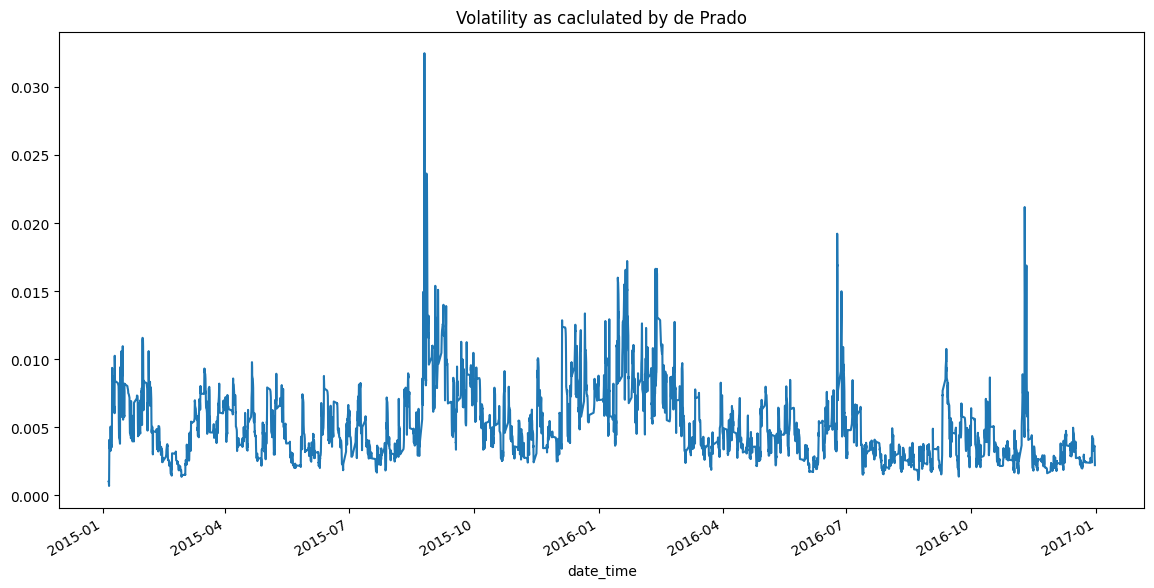

In [9]:
vol.plot(figsize=(14, 7), title='Volatility as caclulated by de Prado')
plt.show()

In [10]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data['close'], threshold=vol.mean())

**Use Snippet 3.4 on a pandas series t1, where numDays=1.**

In [11]:
# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(cusum_events, data['close'])
vertical_barriers.head()

2015-01-02 15:39:14.826   2015-01-02 15:39:14.826
2015-01-02 20:47:02.488   2015-01-02 20:47:02.488
2015-01-04 23:20:12.567   2015-01-04 23:20:12.567
2015-01-05 14:49:36.175   2015-01-05 14:49:36.175
2015-01-05 16:10:05.172   2015-01-05 16:10:05.172
Name: date_time, dtype: datetime64[ns]

**On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.**

In [12]:
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                               t_events=cusum_events,
                                               pt_sl=[1, 1],
                                               target=vol,
                                               min_ret=0.01,
                                               num_threads=1,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=None)

c:\Users\sms20\miniconda3\lib\site-packages\mlfinlab\labeling\labeling.py:55: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for loc, vertical_barrier in events_['t1'].fillna(close.index[-1]).iteritems():
c:\Users\sms20\miniconda3\lib\site-packages\mlfinlab\util\multiprocess.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


In [13]:
triple_barrier_events.head()

,t1,trgt,pt,sl
2015-01-09 17:13:19.851,2015-01-09 17:13:19.851,0.010065,1,1
2015-01-15 13:45:55.324,2015-01-15 13:45:55.324,0.010148,1,1
2015-01-15 14:39:34.621,2015-01-15 14:39:34.621,0.010703,1,1
2015-01-30 10:09:09.112,2015-01-30 10:09:09.112,0.011492,1,1
2015-01-30 14:48:27.262,2015-01-30 14:48:27.262,0.010769,1,1


In [14]:
labels = ml.labeling.get_bins(triple_barrier_events, data['close'])

In [15]:
labels.head()

,ret,trgt,bin
2015-01-09 17:13:19.851,0.0,0.010065,0
2015-01-15 13:45:55.324,0.0,0.010148,0
2015-01-15 14:39:34.621,0.0,0.010703,0
2015-01-30 10:09:09.112,0.0,0.011492,0
2015-01-30 14:48:27.262,0.0,0.010769,0


In [16]:
labels['bin'].value_counts()

0    261
Name: bin, dtype: int64

---
#### 3.2 From exercise 1, use Snippet 3.8 to drop rare labels.

In [17]:
clean_labels = ml.labeling.drop_labels(labels)

In [18]:
print(labels.shape)
print(clean_labels.shape)

(261, 3)
(261, 3)


---
#### 3.3 Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical barrier is the one touched first.
This change was made inside the module CoreFunctions.

---
#### 3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, themodel suggests a side, but not a size of the bet.

1. Derive meta-labels for pt_sl = [1,2] and t1 where num_days=1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
2. Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underllying model (the crossing moveing average has decided the side{-1, 1})

In [19]:
# This question is answered in the notebook: 2019-03-06_JJ_Trend-Following-Question

----
#### 3.5 Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [0, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Use as features: volatility, seial correlation, and teh crossinmg moving averages.
* (c) What is teh accuracy of prediction from the primary model? (i.e. if the secondary model does not filter the bets) What are the precision, recall and FI-scores?
* (d) What is teh accuracy of prediction from the primary model? What are the precision, recall and FI-scores?


In [20]:
# This question is answered in the notebook: 2019-03-07_BBand-Question